In [4]:
import awkward as ak
import uproot
import os
import matplotlib.pyplot as plt
import numpy as np
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from higgs_dna.selections.object_selections import delta_r_mask

In [1]:
from higgs_dna.selections.object_selections import delta_r_mask
import awkward as ak
import correctionlib
import os
from coffea.analysis_tools import PackedSelection
from copy import deepcopy
import numpy as np
from correctionlib.highlevel import model_auto, open_auto
import json
import logging

In [2]:
filename = "/eos/home-b/bbapi/CMSSW_13_3_1_patch1/src/NanoAODProduction/NanoAODv13/test/M35-RunIISummer20UL18NanoAODv2/B680840B-695C-C74A-A2C7-1B54FB6E4587.root"

In [40]:
factory = NanoEventsFactory.from_root(
    filename,
    treepath="Events",
    schemaclass=NanoAODSchema,   # <--- use schemaclass, not schema
)
events = factory.events()

In [6]:
events.fields

['luminosityBlock',
 'Tau',
 'TkMET',
 'Pileup',
 'LHEPart',
 'SubGenJetAK8',
 'GenVtx',
 'HTXS',
 'HLTriggerFinalPath',
 'genWeight',
 'ScoutingCaloMuonOutput',
 'GenIsolatedPhoton',
 'CorrT1METJet',
 'SV',
 'ScoutingPFOutput',
 'TauProd',
 'event',
 'CaloMET',
 'Photon',
 'FatJet',
 'HLT',
 'MET',
 'LowPtElectron',
 'L1',
 'LHEReweightingWeight',
 'GenMET',
 'HLTriggerFirstPath',
 'DST',
 'SoftActivityJetHT10',
 'SoftActivityJetNjets10',
 'LHEPdfWeight',
 'SoftActivityJet',
 'OtherPV',
 'RawPuppiMET',
 'PuppiMET',
 'RawMET',
 'PV',
 'LHEScaleWeight',
 'L1Reco',
 'genTtbarId',
 'L1simulation',
 'GenPart',
 'LHEWeight',
 'SoftActivityJetNjets5',
 'boostedTau',
 'GenJet',
 'DeepMETResponseTune',
 'SoftActivityJetHT2',
 'GenProton',
 'TrigObj',
 'FsrPhoton',
 'SoftActivityJetHT',
 'IsoTrack',
 'Generator',
 'Flag',
 'run',
 'bunchCrossing',
 'Muon',
 'Electron',
 'PSWeight',
 'Jet',
 'GenJetAK8',
 'Rho',
 'GenVisTau',
 'GenDressedLepton',
 'DeepMETResolutionTune',
 'LHE',
 'SubJet',
 'Ch

In [41]:
photons = events.Photon

In [42]:
Jets = events.Jet

In [130]:
def delta_r_manual(obj1, obj2):
    deta = obj1.eta[:, None] - obj2.eta
    dphi = np.abs(obj1.phi[:, None] - obj2.phi)
    dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return np.sqrt(deta**2 + dphi**2)


def photon_preselections(
    photons: ak.Array,
    Jets: ak.Array, 
    events: ak.Array,
    electron_veto=True,
    revert_electron_veto=False,
    year="2023",
    wp_medium=0.2783,
    IsFlag=False):
    """
    Apply full preselection on leptons, jets, and photons.
    Finally return only photons from events that pass all criteria.
    """

    print("Number of events before preselection:", len(events))

    # ------------------------
    # Lepton selection
    # ------------------------
    if year.startswith("2016"):
        ele_pt_cut, mu_pt_cut = 27, 26
    elif year == "2017":
        ele_pt_cut, mu_pt_cut = 33, 29
    elif year == "2018":
        ele_pt_cut, mu_pt_cut = 33, 26
    else:
        raise ValueError(f"Unknown year {year}")

    good_electrons = (
        (events.Electron.pt > ele_pt_cut)
        & (np.abs(events.Electron.eta) < 2.5)
        & (events.Electron.pfRelIso03_all < 0.15)
    )

    good_muons = (
        (events.Muon.pt > mu_pt_cut)
        & (np.abs(events.Muon.eta) < 2.4)
        & (events.Muon.pfRelIso04_all < 0.15)
    )

    one_ele = ak.num(events.Electron[good_electrons]) == 1
    one_mu = ak.num(events.Muon[good_muons]) == 1
    lepton_channel_mask = one_ele | one_mu

    selected_electrons = events.Electron[good_electrons]
    selected_muons = events.Muon[good_muons]
    selected_leptons = ak.concatenate([selected_electrons, selected_muons], axis=1)

    # ------------------------
    # Jet selection
    # ------------------------
    good_jets = (
        (Jets.pt > 20)
        & (np.abs(Jets.eta) < 2.4)
        & (Jets.btagDeepFlavB > wp_medium)
    )
    selected_bjets = Jets[good_jets] 
    print("selected_b_jets: ", selected_bjets)
    at_least_two_bjets = ak.num(selected_bjets) >= 2

    # ------------------------
    # Photon selection (from photon_preselection output)
    # ------------------------
    good_photons = (
        (photons.pt > 10)
        & (np.abs(photons.eta) < 2.5)
    )
    selected_photons = photons[good_photons]
    at_least_two_photons = ak.num(selected_photons) >= 2

    dr = delta_r_manual(selected_leptons, selected_photons)
    dr_mask = ak.all(ak.all(dr > 0.4, axis=-1), axis=-1)

    event_mask = lepton_channel_mask & at_least_two_bjets & at_least_two_photons & dr_mask

    # ------------------------
    # Apply mask — keep length same, empties for failed events
    # ------------------------
    empty_photons = ak.Array([[]] * len(events))
    empty_bjets = ak.Array([[]] * len(events))

    filtered_photons = ak.where(event_mask, selected_photons, empty_photons)
    filtered_jets = ak.where(event_mask, selected_bjets, empty_bjets)
    # keep top 2 by DeepJet score
    top2_bjets = selected_bjets[ak.argsort(filtered_jets.btagDeepFlavB, ascending=False)][:, :2]

    # ------------------------
    # Return photons (order preserved)
    # ------------------------
    return filtered_photons, filtered_jets, top2_bjets

In [131]:
preselected_photons, preselected_jets , top2_bjets = photon_preselections(photons, Jets, events, year="2018")

Number of events before preselection: 3000
selected_b_jets:  [[Jet], [], [], [Jet], [Jet], [], [Jet, ... [], [], [Jet, Jet], [], [], [], []]


In [134]:
top2_bjets[55].pt

<Array [61.6, 29.9] type='2 * float32[parameters={"__doc__": "pt"}]'>

In [125]:
preselected_photons

<PhotonArray [[], [], [], [], ... [], [], [], []] type='3000 * var * photon'>

In [126]:
preselected_jets

<JetArray [[], [], [], [], ... [], [], [], []] type='3000 * var * jet'>

In [109]:
preselected_photons.pt[55]

<Array [32.2, 30.6, 10.5] type='3 * float32[parameters={"__doc__": "p_{T}"}]'>

In [72]:
preselected_photons.fields

['seediEtaOriX',
 'cutBased',
 'electronVeto',
 'hasConversionTracks',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'electronIdx',
 'jetIdx',
 'nSaturatedXtals',
 'numberOfClusters',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'chargedHadronIso',
 'dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'e2nd',
 'e2x5Bottom',
 'e2x5Left',
 'e2x5Right',
 'e2x5Top',
 'e2x5max',
 'e5x5',
 'eBottom',
 'eCorr',
 'eLeft',
 'eMax',
 'eRight',
 'eTop',
 'ecalPFClusterIso',
 'ecalRecHitIsolation',
 'energy',
 'energyErr',
 'energyRaw',
 'esEffSigmaRR',
 'esEnergyOverRawE',
 'eta',
 'etaWidth',
 'hadTowOverEm',
 'haloTaggerMVAVal',
 'hcalPFClusterIso',
 'hoe',
 'mvaID',
 'pfChargedIso',
 'pfChargedIsoPFPV',
 'pfChargedIsoWorstVtx',
 'pfPhoIso03',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'phiWidth',
 'pt',
 'r9',
 'r9Frac',
 'rawPreshowerEnergy',
 's4',
 'seedClusEnergy',
 'seedClusterEta',
 'seedClusterPhi',
 'sieie',
 'sieip',
 'sigmaIetaIetaFrac',


In [127]:
ak.where(ak.num(preselected_photons.mass)!=0)

(<Array [55, 159, 244, ... 2896, 2909, 2929] type='41 * int64'>,)

In [75]:
preselected_photons.mass[55]

<Array [0, 0, 0] type='3 * float32'>

In [63]:
preselected_jets

<JetArray [[], [], [], [], ... [], [], [], []] type='3000 * var * jet'>

In [65]:
ak.where(ak.num(preselected_photons.pt)!=0)

(<Array [55, 159, 244, ... 2896, 2909, 2929] type='41 * int64'>,)

In [128]:
ak.where(ak.num(preselected_jets.pt)!=0)

(<Array [55, 159, 244, ... 2896, 2909, 2929] type='41 * int64'>,)

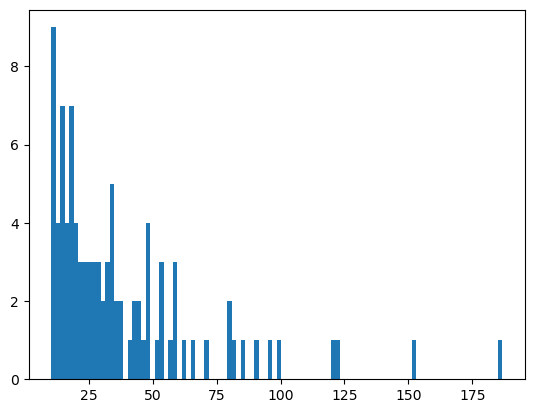

In [68]:
plt.hist(ak.flatten(preselected_photons.pt), bins = 100);

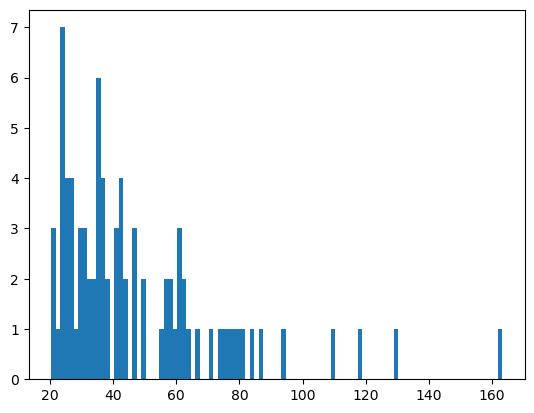

In [69]:
plt.hist(ak.flatten(preselected_jets.pt), bins = 100);

In [57]:
preselected_photons.fields

['seediEtaOriX',
 'cutBased',
 'electronVeto',
 'hasConversionTracks',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'electronIdx',
 'jetIdx',
 'nSaturatedXtals',
 'numberOfClusters',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'chargedHadronIso',
 'dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'e2nd',
 'e2x5Bottom',
 'e2x5Left',
 'e2x5Right',
 'e2x5Top',
 'e2x5max',
 'e5x5',
 'eBottom',
 'eCorr',
 'eLeft',
 'eMax',
 'eRight',
 'eTop',
 'ecalPFClusterIso',
 'ecalRecHitIsolation',
 'energy',
 'energyErr',
 'energyRaw',
 'esEffSigmaRR',
 'esEnergyOverRawE',
 'eta',
 'etaWidth',
 'hadTowOverEm',
 'haloTaggerMVAVal',
 'hcalPFClusterIso',
 'hoe',
 'mvaID',
 'pfChargedIso',
 'pfChargedIsoPFPV',
 'pfChargedIsoWorstVtx',
 'pfPhoIso03',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'phiWidth',
 'pt',
 'r9',
 'r9Frac',
 'rawPreshowerEnergy',
 's4',
 'seedClusEnergy',
 'seedClusterEta',
 'seedClusterPhi',
 'sieie',
 'sieip',
 'sigmaIetaIetaFrac',


[False, False, False, False, False, False, ... False, False, False, False, False]


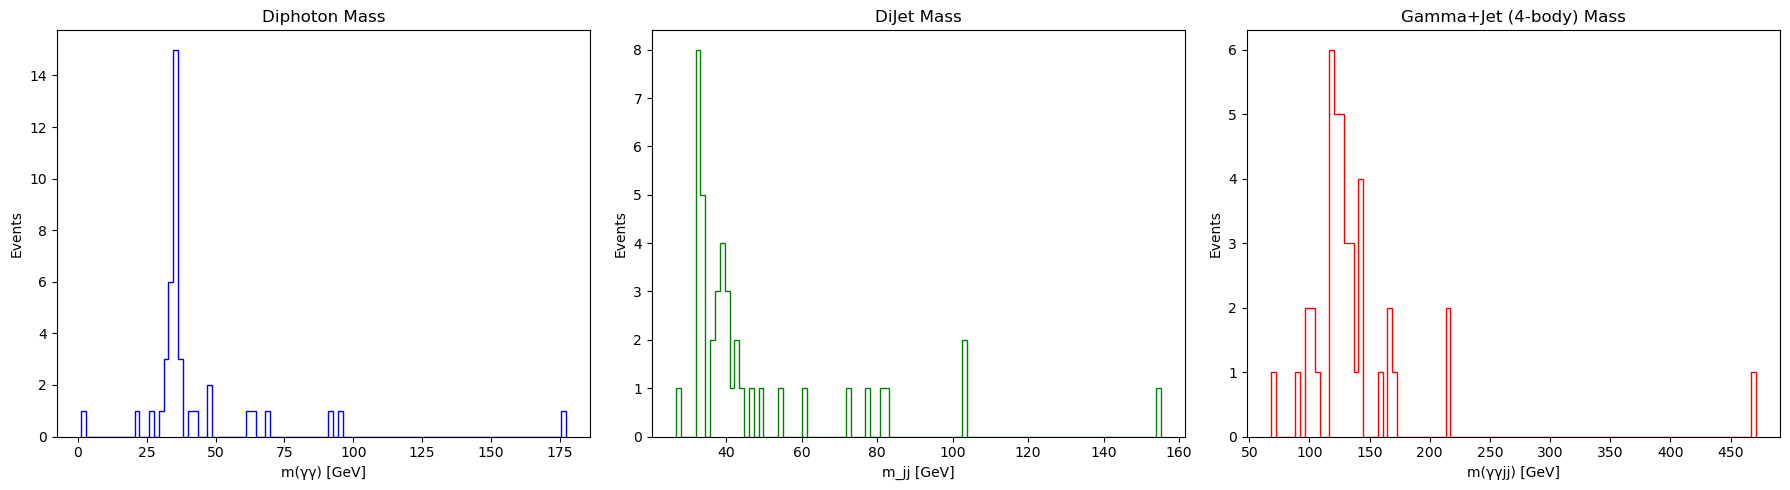

In [135]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# Diphoton combinations (2 photons per combination)
diphoton = ak.combinations(preselected_photons, 2, fields=["p1", "p2"])
diphoton_mass = (diphoton.p1 + diphoton.p2).mass

# Dijet combinations (2 jets per combination)
dijet = ak.combinations(top2_bjets, 2, fields=["j1", "j2"])
dijet_mass = (dijet.j1 + dijet.j2).mass

# Keep only events that have at least one valid diphoton/dijet pair
diphoton_mass = ak.firsts(diphoton_mass)
dijet_mass = ak.firsts(dijet_mass)

m_gg = diphoton_mass[~ak.is_none(diphoton_mass)]
m_gg = ak.to_numpy(m_gg)
m_jj = dijet_mass[~ak.is_none(dijet_mass)]
m_jj = ak.to_numpy(m_jj)

# Step 1: mask valid events
has_diphoton = ak.num(diphoton) > 0
has_dijet = ak.num(dijet) > 0
valid_events = has_diphoton & has_dijet

print(valid_events)

# Step 2: compute gamma+jet mass safely
gammajet_mass = ak.where(
    valid_events,
    (ak.firsts(diphoton.p1 + diphoton.p2) +
     ak.firsts(dijet.j1 + dijet.j2)).mass,
    ak.Array([np.nan] * len(preselected_photons))  # use NaN instead of None
)

# Step 3: filter out NaNs for plotting  
m_ggjj = ak.to_numpy(gammajet_mass[~np.isnan(gammajet_mass)])



# -----------------------------------------
# Plot all three distributions
# -----------------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(m_gg, bins=100, histtype='step', color='blue')
plt.xlabel("m(γγ) [GeV]")
plt.ylabel("Events")
plt.title("Diphoton Mass")

plt.subplot(1, 3, 2)
plt.hist(m_jj, bins=100, histtype='step', color='green')
plt.xlabel("m_jj [GeV]")
plt.ylabel("Events")
plt.title("DiJet Mass")

plt.subplot(1, 3, 3)
plt.hist(m_ggjj, bins=100, histtype='step', color='red')
plt.xlabel("m(γγjj) [GeV]")
plt.ylabel("Events")
plt.title("Gamma+Jet (4-body) Mass")

plt.tight_layout()
plt.show()



[False, False, False, False, False, False, ... False, False, False, False, False]


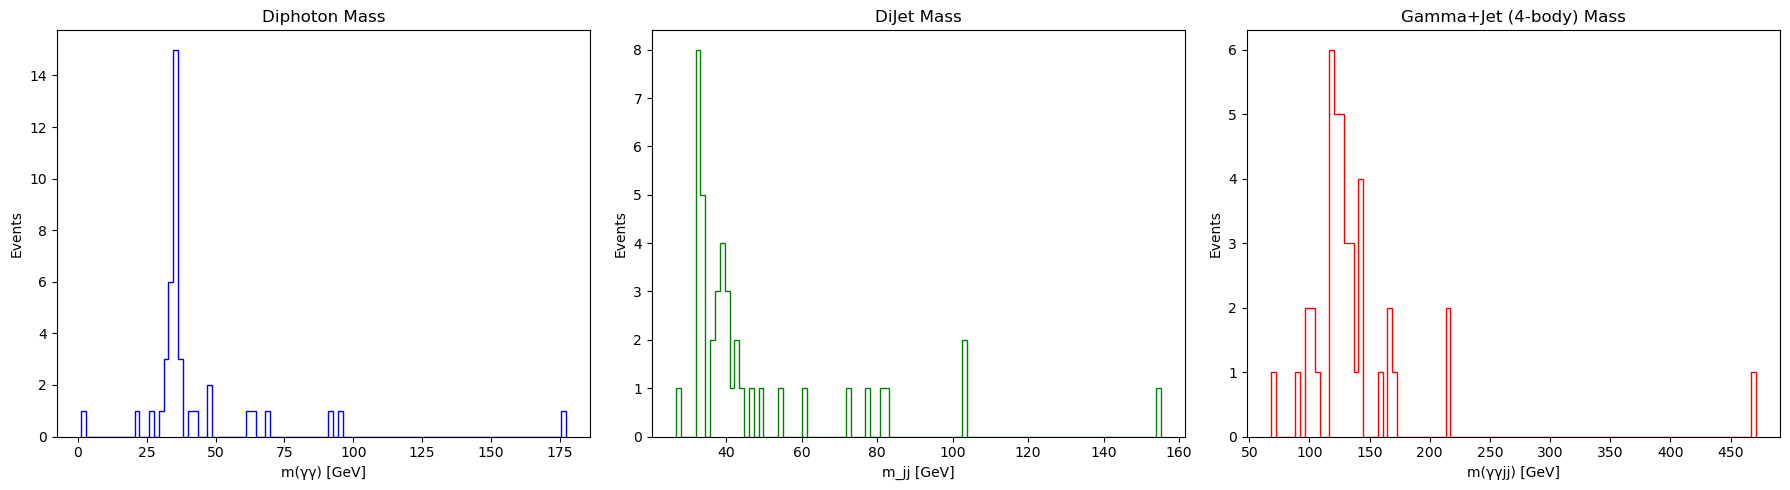

In [136]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# Diphoton combinations (2 photons per combination)
diphoton = ak.combinations(preselected_photons, 2, fields=["p1", "p2"])
diphoton_mass = (diphoton.p1 + diphoton.p2).mass

# Dijet combinations (2 jets per combination)
dijet = ak.combinations(preselected_jets, 2, fields=["j1", "j2"])
dijet_mass = (dijet.j1 + dijet.j2).mass

# Keep only events that have at least one valid diphoton/dijet pair
diphoton_mass = ak.firsts(diphoton_mass)
dijet_mass = ak.firsts(dijet_mass)

m_gg = diphoton_mass[~ak.is_none(diphoton_mass)]
m_gg = ak.to_numpy(m_gg)
m_jj = dijet_mass[~ak.is_none(dijet_mass)]
m_jj = ak.to_numpy(m_jj)

# Step 1: mask valid events
has_diphoton = ak.num(diphoton) > 0
has_dijet = ak.num(dijet) > 0
valid_events = has_diphoton & has_dijet

print(valid_events)

# Step 2: compute gamma+jet mass safely
gammajet_mass = ak.where(
    valid_events,
    (ak.firsts(diphoton.p1 + diphoton.p2) +
     ak.firsts(dijet.j1 + dijet.j2)).mass,
    ak.Array([np.nan] * len(preselected_photons))  # use NaN instead of None
)

# Step 3: filter out NaNs for plotting  
m_ggjj = ak.to_numpy(gammajet_mass[~np.isnan(gammajet_mass)])



# -----------------------------------------
# Plot all three distributions
# -----------------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(m_gg, bins=100, histtype='step', color='blue')
plt.xlabel("m(γγ) [GeV]")
plt.ylabel("Events")
plt.title("Diphoton Mass")

plt.subplot(1, 3, 2)
plt.hist(m_jj, bins=100, histtype='step', color='green')
plt.xlabel("m_jj [GeV]")
plt.ylabel("Events")
plt.title("DiJet Mass")

plt.subplot(1, 3, 3)
plt.hist(m_ggjj, bins=100, histtype='step', color='red')
plt.xlabel("m(γγjj) [GeV]")
plt.ylabel("Events")
plt.title("Gamma+Jet (4-body) Mass")

plt.tight_layout()
plt.show()

In [105]:
ak.firsts((diphoton.p1 + diphoton.p2) +
 ak.firsts(dijet.j1 + dijet.j2)).mass[55]

165.53053283691406

In [102]:
valid_events

<Array [False, False, False, ... False, False] type='3000 * bool'>

In [101]:
ak.Array([np.nan] * len(preselected_photons))

<Array [nan, nan, nan, nan, ... nan, nan, nan] type='3000 * float64'>

In [100]:
diphoton.p1[ak.where(ak.num(diphoton.p1)!=0)]

<PhotonArray [[Photon, Photon, Photon, ... [Photon]] type='41 * var * photon'>

In [111]:
preselected_jets.fields

['jetId',
 'nConstituents',
 'nElectrons',
 'nMuons',
 'nSVs',
 'puId',
 'electronIdx1',
 'electronIdx2',
 'muonIdx1',
 'muonIdx2',
 'svIdx1',
 'svIdx2',
 'hfadjacentEtaStripsSize',
 'hfcentralEtaStripSize',
 'PNetRegPtRawCorr',
 'PNetRegPtRawCorrNeutrino',
 'PNetRegPtRawRes',
 'area',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepCvB',
 'btagDeepCvL',
 'btagDeepFlavB',
 'btagDeepFlavCvB',
 'btagDeepFlavCvL',
 'btagDeepFlavQG',
 'btagPNetB',
 'btagPNetCvB',
 'btagPNetCvL',
 'btagPNetQvG',
 'btagPNetTauVJet',
 'btagRobustParTAK4B',
 'btagRobustParTAK4CvB',
 'btagRobustParTAK4CvL',
 'btagRobustParTAK4QG',
 'chEmEF',
 'chFPV0EF',
 'chHEF',
 'eta',
 'hfsigmaEtaEta',
 'hfsigmaPhiPhi',
 'mass',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'pt',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'hadronFlavour',
 'genJetIdx',
 'partonFlavour',
 'electronIdx1G',
 'electronIdx2G',
 'genJetIdxG',
 'muonIdx1G',
 'muonIdx2G',
 'muonIdxG',
 'electronIdxG']

In [149]:
b_jets = preselected_jets[ak.argsort(preselected_jets.btagDeepFlavB, ascending=False)][:, :2]
b_jets = b_jets[ak.argsort(b_jets.pt, ascending=False)]
b_jets["charge"] = ak.zeros_like(
    b_jets.pt
)  # added this because charge is not a property of photons in nanoAOD v11. We just assume every photon has charge zero...
diJets = ak.combinations(
    b_jets, 2, fields=["bjet_lead", "bjet_sublead"]
)

In [150]:
diJets.bjet_lead.fields

['jetId',
 'nConstituents',
 'nElectrons',
 'nMuons',
 'nSVs',
 'puId',
 'electronIdx1',
 'electronIdx2',
 'muonIdx1',
 'muonIdx2',
 'svIdx1',
 'svIdx2',
 'hfadjacentEtaStripsSize',
 'hfcentralEtaStripSize',
 'PNetRegPtRawCorr',
 'PNetRegPtRawCorrNeutrino',
 'PNetRegPtRawRes',
 'area',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepCvB',
 'btagDeepCvL',
 'btagDeepFlavB',
 'btagDeepFlavCvB',
 'btagDeepFlavCvL',
 'btagDeepFlavQG',
 'btagPNetB',
 'btagPNetCvB',
 'btagPNetCvL',
 'btagPNetQvG',
 'btagPNetTauVJet',
 'btagRobustParTAK4B',
 'btagRobustParTAK4CvB',
 'btagRobustParTAK4CvL',
 'btagRobustParTAK4QG',
 'chEmEF',
 'chFPV0EF',
 'chHEF',
 'eta',
 'hfsigmaEtaEta',
 'hfsigmaPhiPhi',
 'mass',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'pt',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'hadronFlavour',
 'genJetIdx',
 'partonFlavour',
 'electronIdx1G',
 'electronIdx2G',
 'genJetIdxG',
 'muonIdx1G',
 'muonIdx2G',
 'muonIdxG',
 'electronIdxG',
 

In [144]:
photons = preselected_photons[ak.argsort(preselected_photons.pt, ascending=False)]
photons["charge"] = ak.zeros_like(
    photons.pt
)  # added this because charge is not a property of photons in nanoAOD v11. We just assume every photon has charge zero...
diphotons = ak.combinations(
    photons, 2, fields=["pho_lead", "pho_sublead"]
)

In [148]:
diphotons.pho_lead.fields

['seediEtaOriX',
 'cutBased',
 'electronVeto',
 'hasConversionTracks',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'electronIdx',
 'jetIdx',
 'nSaturatedXtals',
 'numberOfClusters',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'chargedHadronIso',
 'dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'e2nd',
 'e2x5Bottom',
 'e2x5Left',
 'e2x5Right',
 'e2x5Top',
 'e2x5max',
 'e5x5',
 'eBottom',
 'eCorr',
 'eLeft',
 'eMax',
 'eRight',
 'eTop',
 'ecalPFClusterIso',
 'ecalRecHitIsolation',
 'energy',
 'energyErr',
 'energyRaw',
 'esEffSigmaRR',
 'esEnergyOverRawE',
 'eta',
 'etaWidth',
 'hadTowOverEm',
 'haloTaggerMVAVal',
 'hcalPFClusterIso',
 'hoe',
 'mvaID',
 'pfChargedIso',
 'pfChargedIsoPFPV',
 'pfChargedIsoWorstVtx',
 'pfPhoIso03',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'phiWidth',
 'pt',
 'r9',
 'r9Frac',
 'rawPreshowerEnergy',
 's4',
 'seedClusEnergy',
 'seedClusterEta',
 'seedClusterPhi',
 'sieie',
 'sieip',
 'sigmaIetaIetaFrac',


In [155]:
prefixes = {"pho_lead": "lead", "pho_sublead": "sublead"}
def diphoton_ak_array(diphotons: ak.Array, prefixes) -> ak.Array:
    """
    Adjust the prefix.
    By default the observables related to each item of the diphoton pair are
    stored preceded by its prefix (e.g. 'lead', 'sublead').
    The observables related to the diphoton pair are stored with no prefix.
    """
    output = {}
    for field in ak.fields(diphotons):
        prefix = prefixes.get(field, "")
        if len(prefix) > 0:
            for subfield in ak.fields(diphotons[field]):
                if subfield != "__systematics__":
                    output[f"{prefix}_{subfield}"] = diphotons[field][subfield]
        else:
            output[field] = diphotons[field]
    return ak.Array(output)

In [158]:
dpakarray = diphoton_ak_array(diphoton,prefixes)

In [161]:
dpakarray.p1.fields

['seediEtaOriX',
 'cutBased',
 'electronVeto',
 'hasConversionTracks',
 'isScEtaEB',
 'isScEtaEE',
 'mvaID_WP80',
 'mvaID_WP90',
 'pixelSeed',
 'seedGain',
 'electronIdx',
 'jetIdx',
 'nSaturatedXtals',
 'numberOfClusters',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'chargedHadronIso',
 'dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'e2nd',
 'e2x5Bottom',
 'e2x5Left',
 'e2x5Right',
 'e2x5Top',
 'e2x5max',
 'e5x5',
 'eBottom',
 'eCorr',
 'eLeft',
 'eMax',
 'eRight',
 'eTop',
 'ecalPFClusterIso',
 'ecalRecHitIsolation',
 'energy',
 'energyErr',
 'energyRaw',
 'esEffSigmaRR',
 'esEnergyOverRawE',
 'eta',
 'etaWidth',
 'hadTowOverEm',
 'haloTaggerMVAVal',
 'hcalPFClusterIso',
 'hoe',
 'mvaID',
 'pfChargedIso',
 'pfChargedIsoPFPV',
 'pfChargedIsoWorstVtx',
 'pfPhoIso03',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'phiWidth',
 'pt',
 'r9',
 'r9Frac',
 'rawPreshowerEnergy',
 's4',
 'seedClusEnergy',
 'seedClusterEta',
 'seedClusterPhi',
 'sieie',
 'sieip',
 'sigmaIetaIetaFrac',
